# Q-Network

DQN을 하기 전에 먼저 Q-Network가 뭔지 알아보고 구현해보자!

이전에 Q-learning은 
* Q-table $Q(s, a)$을 가지고
* (state, action)에 대한 reward를 저장하며, 이를 통해 policy를 도출한다.
* 또한 Q-table을 업데이트해나간다.

그런데, 상태는 무한할 수 있다.(물론 action space도 무한하거나 매우 많을 수 있다. 그러나 여기서는 action space는 유한한 집합이라 가정하자..) 그래서 Q-table을 근사시켜서 표현할 방법이 필요하다.

이를 근사시키기 위해 Neural Network를 쓴 것이 Q-Network이다.

* Q-Network의 network
  * state $s$가 주어졌을 때, $Q(s, a)\ \  \forall a$를 내보내는 network.

### 2번 노트에서 다시 가져옴(Q-learning)
* 새로운 Q 계산
  * $\hat{Q}(s,a) = r(s,a) + \gamma \cdot max_{a_i}Q(s', a_i)$
* Q 업데이트
  * $Q^{new}(s,a) = \alpha \cdot \hat{Q}(s,a) + (1-\alpha)\cdot Q(s, a)$

> 사실 Q 업데이트는 MSE minimization에서 온 것이다. $Q^{true}$를 알 수 없기 때문에 근사시켜서 $r(s,a) + \gamma \cdot max_{a_i}Q(s', a_i)$로 놓고 gradient를 구해보면 위의 Q update식과 같아진다.

여기서 네트워크를 통해 가져올 녀석은 $Q(s, a)$(현재 스텝), $\hat{Q}(s,a)$(다음스텝)이다. 이후에 둘의 mse를 loss로 놓고 SGD를 구하면 Q-Network가 된다.

### Overview
~~~인데... 왜 더 복잡해보이지..~~~
다음 그림의 노란색은 전 step, 녹색은 현 step에서 뽑히는 것을 의미한다.

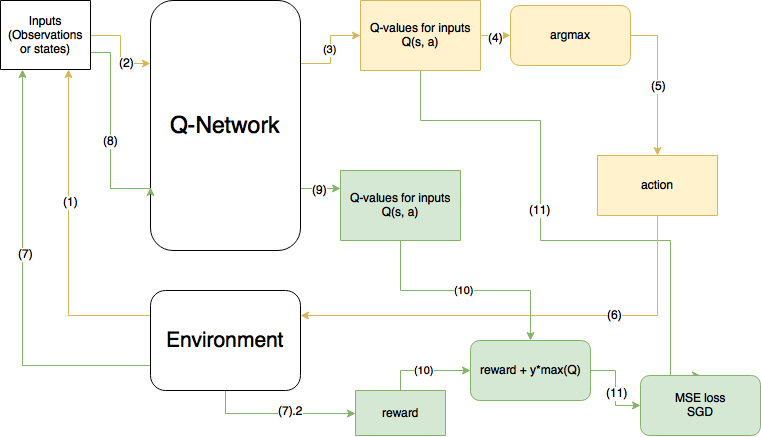

In [42]:
from IPython.display import Image
Image(filename='pngs/Q-Network.png')

In [34]:
import gym
import tensorflow as tf
import numpy as np
tf.logging.set_verbosity(tf.logging.INFO)

env = gym.make("FrozenLake-v0")
tf.reset_default_graph()

n_states = env.observation_space.n
n_actions = env.action_space.n

[2017-07-22 00:10:30,424] Making new env: FrozenLake-v0


In [35]:
# Q-network 그래프 building

inputs = tf.placeholder(shape=[1, n_states],
                        dtype=tf.float32)
W = tf.Variable(tf.random_uniform([n_states, n_actions],
                                  0,
                                  0.01))

Qout = tf.matmul(inputs, W)
predict = tf.argmax(Qout, 1)  # argmax_a Q(s, a)


nextQ = tf.placeholder(shape=[1, n_actions],
                       dtype=tf.float32)

loss = tf.reduce_sum(tf.square(nextQ - Qout))

trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)

updateModel = trainer.minimize(loss)

In [40]:
init = tf.global_variables_initializer()

# hyperparams
y = .99 # gamma
e = 0.1 # epsilon
num_episodes = 2000
t_max = 99

log_step = 200

rewards = []

with tf.Session() as sess:
    sess.run(init)

    for i in range(num_episodes):
        state = env.reset()
        totalReward = 0
        d = False
        timestep = 0
        

        while timestep < t_max:
            timestep += 1
            
            action, Qs = sess.run([predict, Qout],
                               feed_dict={inputs: np.identity(16)[state:state+1]})  # one-hot encoding

            # epsilon-greedy policy
            if np.random.rand(1) < e:
                action[0] = env.action_space.sample()
            
            # step!
            next_state, reward, done, _ = env.step(action[0])
            
            Q1 = sess.run(Qout,
                          feed_dict={inputs: np.identity(16)[next_state:next_state+1]})
            maxQ1 = np.max(Q1)
            
            # Trick: 사실은 action에 대한 loss만 계산해야하니까 나머지는 이전 Q를 그대로 사용해버린다.
            Qhat = Qs
            Qhat[0, action[0]] = reward + y * maxQ1
            
            # gradient 계산 및 업데이트
            _, W1 = sess.run([updateModel, W],
                             feed_dict={inputs: np.identity(16)[state:state+1],
                                        nextQ:  Qhat})

            totalReward += reward
            state = next_state

            if done == True:
                e = 1./((i/50) + 10)
                break
        if i % log_step == 0:
            print("{}-th step...".format(i))
        rewards.append(totalReward)
print("done")

0-th step...
200-th step...
400-th step...
600-th step...
800-th step...
1000-th step...
1200-th step...
1400-th step...
1600-th step...
1800-th step...
done


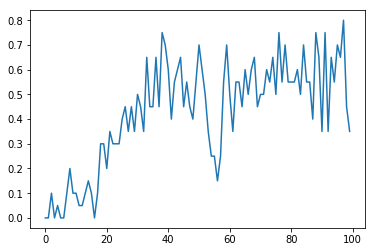

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

mean_rewards = [np.mean(rewards[i:i+20]) for i in range(0, len(rewards), 20)]
plt.plot(mean_rewards)
plt.show()

위의 결과를 보면 한 800(40*20)번째 에피소드부터 괜찮게 함을 볼 수 있다.